***Submitting late by 7 days using days 17-24***

# Maman 16
***Youtube:*** 
Hi Idan I have a sick 7 month baby didn't record any possibility to record later?
question 1: 

question 2:

# Question 1

# ***part 1***

In [1]:
#loading the dataset
%pip install datasets
import torch
from torch import nn
import datasets as ds
from pprint import pprint
from torchtext.vocab import build_vocab_from_iterator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 12.9 MB/s eta 0:00:00


In [2]:
# Alef data loading
dataset = ds.load_dataset("glue", "sst2")
sentence_list = dataset["train"]["sentence"]
labels_list = dataset["train"]["label"]
# Create vocabulary
tokenize = lambda x: x.split()
tokenized = list(map(tokenize, sentence_list)) # list of sentences, each sentence list of tokens

vocab = build_vocab_from_iterator(tokenized, specials=["<UNK>"], min_freq=5)
vocab.set_default_index(0)

# Convert tokens to their serial numbers.
func = lambda x: torch.tensor(vocab(x))
integer_tokens=list(map(func, tokenized))
label_tensors=list(map(torch.tensor, labels_list))

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
# Network definition
''' The recurrent net for classifying sentences. Page 161, learning guide.'''

class FasterDeepRNNClassifier(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_rnn_layers=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding  = nn.Embedding(len(vocab), embed_dim)  # word2vec embedding
        # a multi-layer Elman RNN with tanh (default):
        self.rnn_stack  = nn.RNN(embed_dim, 
                                 hidden_dim, 
                                 num_rnn_layers)

        self.linear     = nn.Linear(hidden_dim, 2)
        self.logsoftmax = nn.LogSoftmax(dim=0)

    def forward(self, sentence_tokens, hidden=None):
      # Input processing.
      sentence_embeddings = self.embedding(sentence_tokens)
      sentence_embeddings = sentence_embeddings.unsqueeze(1)

      if hidden is None: # If we are at the beginning of a sentence,
        #                            enter it normally into the network.
        hidden_state_history, h_t = self.rnn_stack(sentence_embeddings)
      else: # Enter the rest of the sentence, 
        #       with the last hidden situation we reached.
        hidden_state_history, h_t = self.rnn_stack(sentence_embeddings, hidden)

      class_scores     = self.linear( hidden_state_history[-1,0,:])  
      logprobs         = self.logsoftmax(class_scores)
      
      # Return the log probabilities of classification, 
      # and the new hidden state.
      return logprobs, h_t

In [16]:
embed_dim = 10
hid_dim = 15
model    = FasterDeepRNNClassifier(embed_dim=embed_dim, hidden_dim = hid_dim , num_rnn_layers=1)

In [17]:
''' train function '''
def iterate_one_sentence(tokens, label, train_flag, t, step=True, detach=True):
    if train_flag: # Training mode
        model.train()
        optimizer.zero_grad()

        hidden = None # Last hidden state.
        # Enter the [:T-t] part of the sentence into the net.
        T =  len(tokens)
        if t < T:
            y_pred_t, hidden = model(tokens[:-t])
            # Detach the gradient calculations from this part of the sentence.
            if detach: 
              hidden = hidden.detach()
        
        # Insert the second part of the sentence, word after word, 
        # to illustrate the gradients.
        for token in tokens[-t:]:
            y_pred_t, hidden = model(torch.unsqueeze(token, 0), hidden)

        loss= -y_pred_t[label] #Cross Entropy
        loss.backward()
        if step: 
          optimizer.step()
    
    else: # Test mode
        model.eval()
        y_pred_t=model(tokens)
        model.train()
    
    # Extract whether the classification was successful.
    with torch.no_grad():
        predicted_labels = y_pred_t.argmax()
        success = (predicted_labels == label)

    return success

In [47]:
''' Create the model and train it. '''
from tqdm import tqdm

# Split the data set into a training and test sets.
test_split = len(integer_tokens)*8//10
train_tokens = integer_tokens[:test_split]
train_labels = label_tensors[:test_split]
test_tokens = integer_tokens[test_split:]
test_labels = label_tensors[test_split:]

torch.manual_seed(0)
model = FasterDeepRNNClassifier(10, 8) # Create the model.
optimizer = torch.optim.AdamW(model.parameters())

# Train the model.
t = 5
num_samples, epochs = 100, 10

for epoch in range(epochs):
    correct_predictions = torch.tensor([0.])
    for idx in tqdm(range(num_samples)):
        correct_predictions += iterate_one_sentence(train_tokens[idx],
                                                    train_labels[idx],
                                                    train_flag=True, t=t)
        acc = correct_predictions/num_samples
    
    if (epoch+1)%3==0:
        print("Epoch",epoch+1," acc:",acc.item())

print("\nEpoch",epoch+1," acc:",acc.item())

100%|██████████| 100/100 [00:00<00:00, 324.66it/s]


Epoch 3  acc: 0.5899999737739563


100%|██████████| 100/100 [00:00<00:00, 343.51it/s]


Epoch 6  acc: 0.7799999713897705


100%|██████████| 100/100 [00:00<00:00, 247.92it/s]


Epoch 9  acc: 0.8299999833106995


100%|██████████| 100/100 [00:00<00:00, 241.52it/s]


Epoch 10  acc: 0.8500000238418579


In [48]:
# Function to display the gradient at any point in time. 
def backward_hook(module, grad_input, grad_output):
    # grad_output: Gradient of the loss w.r.t. the layer output, dh(out)_t.
    for grad in grad_output:
        if grad is not None:
            grads.append(grad) # dC/dh_t

    # grad_input: Gradients of the loss w.r.t the layer inputs.
    # grad_input[0] = dC/dx_t , grad_input[1] = dC/dh_(t-1)
    grads.append(grad_input[1])

In [62]:
# indices of sentences with length at least a bit longer than t
long_indx_list = [indx_long for (indx_long, sent) in enumerate(train_tokens) if len(sent)>=t+3]

In [73]:
# Sample input for which the gradient is not calculated after time T-t. 
idx = long_indx_list[len(long_indx_list)//2]
print('sentence index ', idx)
T = len(train_tokens[idx]) # Sentence length.

print('Sentence length', T)
grads = [] # Each cell contains the gradients at a particular point in time.

# Activate the function we wrote above and enter the sentence to the net.
handle = model.rnn_stack.register_full_backward_hook(backward_hook)
iterate_one_sentence(train_tokens[idx], train_labels[idx],
                    train_flag=True, t=t, step=False, detach=True)
handle.remove() # Disable the function we wrote above.

# The values stored here are: [dC/dh_22, dC/dh_21],
# [dC/dh_21, dC/dh_20], [dC/dh_20, dC/dh_19], ....
# This means there are duplicates in the list, 
# so we will only take the unique values.
relevant_grads = grads[::2] + grads[-1::]
for i, grad in enumerate(relevant_grads):
    print(f"Time : {T-1-i}\n{grad}")

sentence index  26884
Sentence length 23
Time : 22
tensor([[[-0.0914, -0.0074, -0.1094, -0.1292, -0.0425,  0.1479,  0.0494,
           0.1155]]])
Time : 21
tensor([[[ 0.0013,  0.0578, -0.0173, -0.0029,  0.0691,  0.0045,  0.0744,
           0.0466]]])
Time : 20
tensor([[[ 0.0399, -0.0190,  0.0090,  0.0187, -0.0111, -0.0411,  0.0064,
          -0.0083]]])
Time : 19
tensor([[[-0.0021,  0.0018,  0.0022,  0.0023, -0.0246,  0.0168, -0.0116,
          -0.0104]]])
Time : 18
tensor([[[-0.0009,  0.0047,  0.0012, -0.0035,  0.0091, -0.0030,  0.0012,
          -0.0032]]])
Time : 17
tensor([[[0., 0., 0., 0., 0., 0., 0., 0.]]])


number of time stamps with relevant gradiens 6


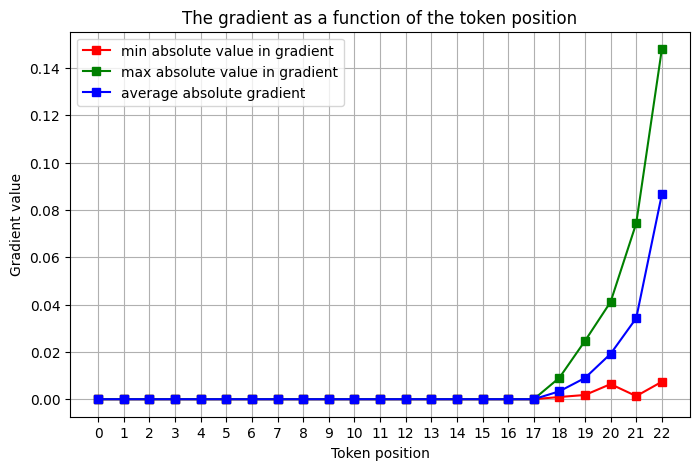

In [75]:
''' Plot the gradient as a function of the token position. '''
import matplotlib.pyplot as plt
import numpy as np

print('number of time stamps with relevant gradiens', len(relevant_grads))
relevant_grads = [torch.abs(rg) for rg in relevant_grads]
grads_mins = [torch.min(t).item() for t in list(reversed(relevant_grads))]
grads_maxs = [torch.max(t).item() for t in list(reversed(relevant_grads))]
grads_avg = [torch.mean(t).item() for t in list(reversed(relevant_grads))]

'''
Since 'detach' is applied after T-t tokens,
the system detachs all gradient calculations up to that time,
and starts again from the same token as a leaf.
All the gradients at the beginning till T-t are set manually to zeros,
so far.
'''
grads_zero = [0.0]*(T-t-1)
grads_mins = grads_zero + grads_mins
grads_maxs = grads_zero + grads_maxs
grads_avg = grads_zero + grads_avg

# Plot gradient sizes.
ax = plt.figure(figsize=(8, 5))
plt.xticks(np.arange(T), np.arange(T))
plt.plot(np.arange(T), grads_mins, 's-r')
plt.plot(np.arange(T), grads_maxs, 's-g')
plt.plot(np.arange(T), grads_avg, 's-b')
plt.grid()
plt.title('The gradient as a function of the token position')
plt.ylabel("Gradient value")
plt.xlabel("Token position")
plt.legend(['min absolute value in gradient', 'max absolute value in gradient', 'average absolute gradient'])
plt.show()

### Question 2, Implement a simple forget gate:
$h_t= R_t \hat h_t$, where $\hat h_t $  as in Elman cell and forgetting gate $R_t \in [0,1]$ dependent on the current input only and  $R_{t+1}=F(W_{hx}x_t + W_{hh}h_t + b_r)$. Non-linear activation function $F$ is selected as a sigmoid function as gating is between $[0,1]$.

In [80]:
class ElmanForgetCell(nn.Module):
    '''
    Constructor: creates a new ElmanReset RNN cell.
    Input:
       n_input - dimension of the input units to the cell.
       n_hid' - dimension of the hidden state of the cell.
    '''
    def __init__(self, n_in, n_hid):
        # create the Module object
        super().__init__()

        # store dimensions
        self.n_in = n_in
        self.n_hidden = n_hid

        # set weight matrices
        self.W_hx = nn.Parameter(torch.empty((n_hid, n_in)))
        self.W_hh = nn.Parameter(torch.empty((n_hid, n_hid)))
        self.W_rx = nn.Parameter(torch.empty((n_hid, n_in)))
        self.W_rh = nn.Parameter(torch.empty((n_hid, n_hid)))

        # initialize weights using Xavier's initialization
        wb = (6 / (n_in + 2*n_hid)) ** 0.5
        nn.init.uniform_(self.W_hx, -wb, wb)
        nn.init.uniform_(self.W_hh, -wb, wb)
        nn.init.uniform_(self.W_rx, -wb, wb)
        nn.init.uniform_(self.W_rh, -wb, wb)

        # set bias vectors (as column vectors)
        self.b_h = nn.Parameter(torch.zeros((n_hid, 1)))

        # initialize forget biases of an LSTM to 1.0, for not forgetting at the start
        self.b_r = nn.Parameter(torch.ones((n_hid, 1))) 
        # set initial hidden state
        self.initial_h = nn.Parameter(torch.zeros(n_hid)) # be similar to simple Elman at the start

        # set current hidden state
        self.h = None
        self.reinit_hidden()
    
    '''
    Resets the hidden state of the cell to its initial value.
    '''
    def reinit_hidden(self):
        # clone self.initialHiddenState (so outsiders won't accidentally change it)
        self.h = self.initial_h.clone()
        self.h.retain_grad() # convert back to a leaf tensor, such that it contains a .grad attribute
   
   
    def forward(self, X):
        # reshape x and h so they're column vectors
        X = X.reshape((-1, 1));
        h = self.h.reshape((-1,1))
        # calculate candidate hidden state and forget-gate vector
        h_hat = torch.tanh( torch.matmul(self.W_hx, X) + 
                           torch.matmul(self.W_hh, h)  + 
                           self.b_h)
        R = torch.sigmoid( torch.matmul(self.W_rx, X) + 
                          torch.matmul(self.W_rh, h) + 
                          self.b_r)
        
        # use them to calculate the next hidden state
        self.h = (h_hat * R).reshape(-1) # direct product

    '''
    Returns a string containing information about the input and hidden dimensions
      of the cell. The output is of the format 'n_in={n_in}, n_out={n_out}'.
    '''
    def extra_repr(self):
        return f'n_in={self.n_in}, n_hidden={self.n_hidden}'
    
     

In [76]:
# load dataset
dataset = ds.load_dataset("glue", "sst2")

sentence_list=dataset["train"]["sentence"]
labels_list=dataset["train"]["label"]
tokenize = lambda x: x.split()
tokenized=list(map(tokenize, sentence_list))

vocab=build_vocab_from_iterator(tokenized, specials=["<UNK>"],min_freq=5)
vocab.set_default_index(0)

func = lambda x: torch.tensor(vocab(x))
integer_tokens=list(map(func,tokenized))
label_tensors=list(map(torch.tensor,labels_list))

test_split=len(integer_tokens)*8//10
train_tokens=integer_tokens[:test_split]
train_labels=label_tensors[:test_split]
test_tokens=integer_tokens[test_split:]
test_labels=label_tensors[test_split:]

  0%|          | 0/3 [00:00<?, ?it/s]

In [81]:
'''
A sentence classifier based on a deep recurrent network that makes use of ElmanForget
  cells.
'''
class ElmanForgetClassifier(nn.Module):
    '''
    Constructor: creates a new deep recurrent sentence classifier (based on an 
      architecture of my design), incorporating ElmanReset cells.
    Input:
      vocab_size  - the size of the vocabulary from which the input sentences are drawn.
      embed_dim   - dimension of word embeddings for this vocabulary (which the model learns)
      hidden_dim  - dimension of hidden state for the ElmanReset cells incorporated in the model.
      num_classes - the number of output classes of the classifier.
    '''
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=2):
        # create the Module object
        super().__init__()
        
        # set a learned word embedding for this vocabulary
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # set 2 ElmanReset cells to which embedded sentences will be fed
        self.cell_1 = ElmanForgetCell(embed_dim, hidden_dim)
        self.cell_2 = ElmanForgetCell(hidden_dim, hidden_dim)

        # set a shallow classifying head
        self.linear = nn.Linear(hidden_dim, num_classes)
        self.logsoftmax = nn.LogSoftmax(dim=0)
    
    '''
    Forwards a sentence through the network.
    Input:
      > 'sentence' - list (or list-like) of indices of the tokenized words in the
        input sentence, in the same order they appear in the sentence.
    Returns a tensor of shape (num_classes,) containing the log of the output
      class probabilities produced by the classifier.
    '''
    def forward(self, sentence):
        # reset the cells' hidden state
        self.cell_1.reinit_hidden()
        self.cell_2.reinit_hidden()

        # sequentially process each token 
        for token in sentence:
            # embed the token
            embedded_token = self.embedding(token)
            # feed it through the recurrent cells
            self.cell_1(embedded_token)
            self.cell_2(self.cell_1.h)
        
        # feed the final hidden state through the classifying head
        class_scores = self.linear(self.cell_2.h)
        logprobs = self.logsoftmax(class_scores)
        return logprobs
     

In [82]:
def iterate_one_sentence(model, optimizer, tokens,label,train_flag):
	if train_flag:
		model.train()  
		optimizer.zero_grad()
		y_model=model(tokens)
		loss= -y_model[label] #Cross Entropy
		loss.backward()
		optimizer.step()
	else:
		model.eval()
		y_model=model(tokens)
		model.train()
	with torch.no_grad():
		predicted_labels = y_model.argmax()
		success = (predicted_labels == label)
	return success

In [84]:
BATCH_SIZE, EPOCHES = 200, 50
def train_model(model, optimizer):
	epoch_acc = []

	parameters = list(model.parameters())
	avg_grad_norms=torch.zeros(EPOCHES)
	for epoch in tqdm(range(EPOCHES)):
		correct_predictions=torch.tensor([0.])
		grad_norm_temp=torch.zeros(BATCH_SIZE)
		for idx in range(BATCH_SIZE):
			sentence = sentence_list[idx]
			correct_predictions += iterate_one_sentence(model, optimizer, train_tokens[idx],train_labels[idx],train_flag=True)
			norms = [p.grad.detach().abs().max() for p in parameters if p.grad is not None]
			grad_norm_temp[idx] = torch.max(torch.stack(norms))
		avg_grad_norms[epoch] = grad_norm_temp.mean()
		
		acc=correct_predictions/BATCH_SIZE
		epoch_acc.append(acc)
		# if epoch%3==0:
		# 	print("Epoch",epoch," acc:",acc.item())
	return epoch_acc, grad_norm_temp

In [85]:
# create a model for our data, and an optimizer for it
model = ElmanForgetClassifier(vocab_size=len(vocab),
                             embed_dim=10,
                             hidden_dim=10,
                             num_classes=2)
optimizer = torch.optim.Adam(model.parameters())

In [86]:
acc, grad_norm_temp = train_model(model, optimizer)

100%|██████████| 50/50 [01:01<00:00,  1.24s/it]


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'Train accuracy')

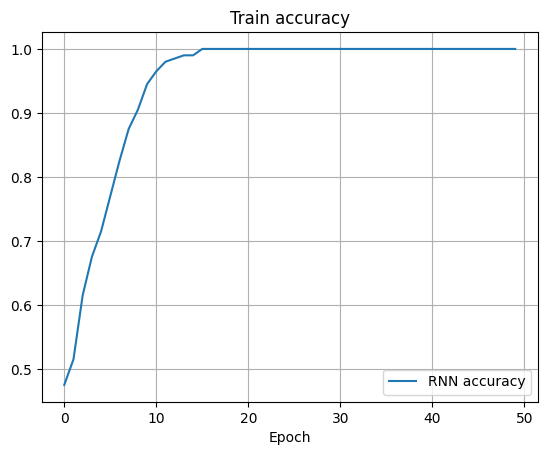

In [88]:
plt.plot(acc, label="RNN accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.grid()
plt.title("Train accuracy")